# Präambel

Die Praktikumsbeschreibung ist als [Jupyter Notebook](https://jupyter.org/) realisiert. Dadurch lassen sich Code-Beispiele selbst ausprobieren.
<!---
Das interaktive Notebook ist als Online-Version über die URL https://mrt.kit.edu erreichbar. TODO
Alternativ können Sie sich auch die Dateien herunterladen und diese lokal auf Ihrem Rechner ausführen.
-->

Eine Anleitung für die Benutzung und Installation von Jupyter Notebooks findet sich im Dokument [JupyterIntroduction.ipynb](JupyterIntroduction.ipynb).

Der folgende Block enthält Code für die Visualisierung, der für das Verständnis der Thematik nicht notwendig ist, aber exakt einmal vor der Verwendung ausgeführt werden muss. Dadurch können die nachfolgenden Code-Blöcke jeweils Abschnittsweise unabhängig voneinander ausgeführt werden. Innerhalb eines Abschnitts ist die Reihenfolge der Code-Blöcke wichtig, da zuerst Variablen und Funktionen definiert werden und diese dann in einem darauf folgenden Code-Block verwendet werden.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt

# Motivation und Einführung SLAM

Im Praktikumsversuch sollen Sie einen Staubsauger-Roboter so programmieren, dass er sich autonom durch einen Raum mit Hindernissen bewegen kann.
Der Staubsauger-Roboter kann über einen externen Computer programmiert werden und ist mit einem einzeiligen LiDAR-Sensor ausgestattet, welcher mehrere Laserstrahlen aussendet und so die Entfernung zu Hindernissen messen kann.
Die Algorithmen die für diese Aufgabe zum Einsatz kommen sind sogenannte SLAM-Methoden.

SLAM steht für "Simultaneous Localization And Mapping" und ist in der Robotik der Sammelbegriff für mathematische Verfahren zur
- Bestimmung der aktuellen Position des Roboters, sowie der
- Schätzung und Aufzeichnung der Umgebung (bzw. der Hindernisse) in Form einer Karte.

Das Ziel ist, dass ein Roboter sich in einer unbekannten Umgebung mit Hilfe seiner Sensoren zurecht finden und sich darin autonom bewegen kann. Beispiele für mögliche Einsatzszenarien reichen vom Haushaltsroboter (Staubsauger-Roboter, Rasenmäher-Roboter) bis zu autonomen Transportfahrzeugen in Fertigungshallen.
Dabei wird stets vorrausgesetzt, dass sich der Roboter in der betreffenden Umgebung bewegen und Hindernisse wahrnehmen kann.

Um dieses Ziel zu erreichen, müssen die Position des Roboters und die Karte der Umgebung (Positionen der Hindernisse) gleichzeitig geschätzt und schrittweise aktualisiert werden.
Karte und Position des Roboters werden zu einem Zustand zusammengefasst, welcher die gesammelten Informationen zusammenfasst.
Zur genauen Schätzung des Zustands existieren verschiedene mathematische Ansätze. Ein bekannter solcher Ansatz (FastSLAM) wird im Folgenden vorgestellt und bildet die Grundlage für diesen Versuch.

Inhalt und Notation dieses Skripts orientieren sich an dem Standardwerk *Probabilistic Robotics (Thrun, 2005)*, welches eine umfassende Einführung in das Thema SLAM bietet.

In diesem Skript werden zuerst der Bayes- und Kalman-Filter als Grundlage wiederholt, um danach den Partikelfilter genauer einzuführen.
Bewegungs- und Messmodell sind immer anwendungsspezifisch und werden dann für den Roboter erläutert.
Zuletzt werden diskrete Karten (occupancy grid maps) und der passende SLAM-Algorithmus (FastSLAM) vorgestellt.


# Grundlagen

## Bayes-Filter

Der Bayer-Filter ist ein Algorithmus zur allgemeinen Vorhersage und Überprüfung eines Zustandes. Dabei ist im Algorithmus weder die Art des Zustandes (z.B. Flasche offen/zu, Licht an/aus, Position eines Roboters) noch die Art der Wahrscheinlichkeitsdichteverteilung festgelegt, mit welcher dieser Zustand verteilt ist.

Für den Fall einer Positionsschätzung entspricht der Zustand des Filters etwa den Ortskoordinaten $x_t$ des Roboters zum Zeitpunkt $t$.
Der Bayes-Filter schätzt nun die Wahrscheinlichkeitsverteilung $p(x_t)$, welche die gesammelte Information über die Position zusammenfasst.
Gegenüber einer einzelnen Schätzung hat eine Wahrscheinlichkeitsverteilung den Vorteil, dass mehrere Hypothesen getrackt werden können und Unsicherheiten/Konfidenzen zu den Schätzungen angegeben werden können.

Für jeden Zeitschritt werden zwei verschiedene Berechnugsschritte des Bayes-Filter unterschieden:
- Prädiktionsschritt (Aktualisierung der Zustandsverteilung aufgrund der Bewegung des Roboters) und dem 
- Innovationsschritt, bzw. Filterschritt (Aktualisierung der Zustandsverteilung aufgrund neuer Messungen).

Der Bayes-Filter ist ein rekusiver Algorithmus, d.h. er führt den Prädiktionsschritt und den Innovationsschritt immer wieder im Wechsel aus.
Oft wird von einer normalverteilten Wahrscheinlichkeitsdichtefunktion des Zustands ausgegangen.
Diese Filter bilden eine Familie innerhalb der rekursiven Zustand-Schätzer.
Der bekannteste Vertreter dieser Art von Schätzern ist der Kalman-Filter.


## Kalman-Filter und erweiterter Kalman-Filter

Der Kalman-Filter ist eine Umsetzung des Bayes-Filters für Systeme mit linearer Zustandsübergangsgleichung und normalverteiltem System- und Messrauschen.
Die Zustandsübergangsgleichung ist ein Modell für das zu beschreibende System.
Sie modelliert den Übergang des Zustandes vom Zeitpunkt $t-1$ zum Zeitpunkt $t$.

Ein einfaches Beispiel ist die Bewegung eines Objektes mit konstanter Geschwindigkeit $v$. Die gemessene Geschwindigkeit ist dann

$$v_t = v + \text{Messrauschen}$$

Der Zustand $x$ entspricht der zurückgelegten Strecke des Objekts und die Übergangsgleichung lautet 

$$x_t = x_{t-1} + v\cdot t + \text{Systemrauschen}$$

Der Kalman-Filter schätzt in den zwei alternierenden Schritten für den Zustand den Mittelwert und die Kovarianz der Gaußverteilung.
Die Varianzen und Kovarianzen der Schätzung und der Messungen werden dabei als Maß für die Unsicherheit und Zuverläsigkeit betrachtet und können so verglichen werden.
So kann beispielsweise dem Modell weniger Bedeutung zugeschrieben werden, wenn dessen Voraussage fortlaufend schlechte Ergebnisse liefert.
Der Gewichtungsfaktor, welcher Prädiktion und Messung gewichtet, heißt Kalman-Gain.

Im Falle der Nichtlinearität der Zustandsübergangsgleichung ist z.T. eine Linearisierung der Übergangsgleichung um den aktuell geschätzten Zustand sinnvoll. Der Algorithmus wird dann erweiterter (bzw. oft auf Englisch "extended") Kalman-Filter genannt.

Wenn das System nichtlinear ist und der Zusammenhang zwischen Beobachtung und Zustand mit unbekannter Wahrscheinlichkeitsdichte erfolgt, so kann der Kalman-Filter nicht angewandt werden. In diesem Fall ist eine mögliche Alternative der Partikel-Filter.

## Partikel-Filter

Beim Kalman-Filter gilt u.a. die Einschränkung, dass die Unsicherheit des aktuellen Zustands normalverteilt sein muss. Außerdem muss das Systemmodell linear sein. 

Der Partikel-Filter ist eine Variante eines Bayesschen Filters, das keine parametrische Wahrscheinlichkeitsverteilung verwendet. Stattdessen wird diese implizit über eine Menge an Samples (Partikeln) definiert. Der Zustand des Filters entspricht der Menge $X_t$ der Zustände $x^m_t$ der Partikel.

$$ X_t := x^0_t, x^1_t, ..., x^{(M-1)}_t $$

Dabei ist $M$ die Anzahl der Partikel des Filters. Jedes Partikel $x^m_t$ für $0 \le m \le M-1$ steht für eine Zustandshypothese des Filters zum Zeitpunkt $t$.

Mit einem Partikel-Filter lassen sich fast beliebige Verteilungen repräsentieren, eingeschränkt ist der Filter lediglich durch die endliche Anzahl der Partikel.

Im Folgenden werden die einzelnen Schritte des Partikel-Filters erläutert. Zuerst wird eine initiale Schätzung vorgenommen, die den Startwert des Filters festlegt, dann wird im Prädiktionsschritt eine Vorhersage über das Verhalten der einzelnen Partikel im nächsten Zeitschritt getroffen und diese Vorhersage dann im letzten Schritt, dem Filterschritt, mit der Messung verglichen und die prädizierten Partikel entsprechend angepasst.

In diesem Beispiel ist der Zustand die Position eines Objektes entlang der x-Achse. Zur bestimmung des Zustandes werden Beobachtungen vorgenommen. Der Partikelfilter soll daraus die Wahrscheinlichkeit einer bestimmten Position auf der x-Achse bestimmen.

### Initialisierung

Initialisiert werden die Partikel des Partikelfilters je nach Vorwissen. Da im folgenden Beispiel kein Vorwissen existiert, wird eine Gleichverteilung angenommen.
Für das spätere Resampling wird jedem Partikel eine Wichtigkeit zugeordnet, der sogenannte Importance Factor.
Der Importance Factor aller Partikel wird gleich initialisiert und muss sich für den hier verwendeten Resampling-Algorithmus zu eins summieren.

Am Ende des Code-Blocks wird der aktuelle Zustand aller Partikel visualisiert. Da die Position nur in eine Dimension (x-Achse) bestimmt wird, repräsentiert die Höhe der Partikel den Importance Factor. Da mehrere Partikel auf der gleichen Position liegen können und das aus dem Plot nicht immer ersichtlich ist, wird außerdem noch ein Histogram über alle Partikel, aber ohne Berücksichtigung des Importance Factor, erstellt.

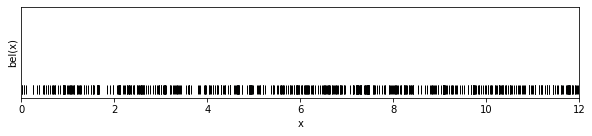

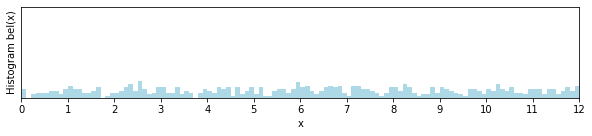

In [2]:
import random
import numpy as np
from scipy.stats import norm
import sys
sys.path.append('lecture_modules/')
from b2_slam import particle_filter

# Actual position of robot
position = 3.0

# Initialization of particles
particles = [np.random.uniform(0.0, 12.0) for i in range(500)]
importance = [1.0 / len(particles) for i in range(len(particles))]

particle_filter.plot_particles(particles, importance)

### Prädiktionsschritt

Wie schon im Bayes- und Kalman-Filter besteht die Hauptschleife des Partikel-Filters aus einem Präditkionsschritt und einem Filterschritt.

Für den Prädiktionsschritt werden alle Partikel in Richtung der prädizierten Bewegung verschoben.
Um die Unsicherheit der Bewegung zu modellieren, wird zusätzlich das Systemrauschen addiert.

Hier zeigt sich die zweite Stärke des Partikel-Filters gegenüber des Kalman-Filters. Da der Prädiktionsschritt auf einzelne Patikel angewendet wird und auch keine Kovarianz angepasst werden muss, kann der Prädiktionsschritt nichtlinear sein.

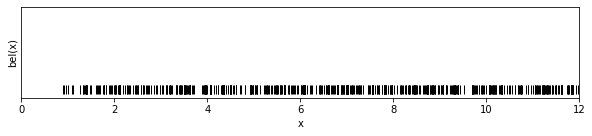

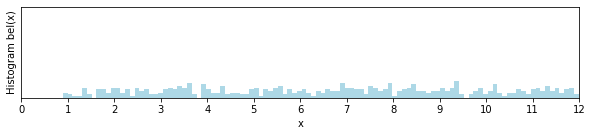

In [3]:
def predict(position, particles, step):
    # Move forward with uncertainty
    predicted_particles = [p + step + random.gauss(0.0, 0.1) for p in particles]
    position += step
    return position, predicted_particles

position, particles = predict(position, particles, 1.0)
particle_filter.plot_particles(particles, importance)

### Filterschritt

Nachdem eine neue Messung erhalten wurde, besteht der Filterschritt des Partikelfilter aus zwei aufeinander folgenden Schritten. Der erste Schritt berechnet für jeden Partikel den Importance Factor neu, der beschreibt, wie gut die Messung zum Zustand des jeweiligen Partikels passt. Der zweite Schitt verteilt die Partikel auf Basis des Importance Factors neu.

#### Gewichtung

Das Gewicht $w^m_t$ beschreibt, wie plausibel die Messung $z_t$ ist, gegeben den Zustand des Partikel $p^m_t$:

$$ w^m_t = p\left(z_t \middle| x^m_t\right) $$

Eine Voraussetzung für den folgenden Schritt (Resampling) ist, dass die Summe über alle Partikelgewichte eins ergibt.

In diesem Beispiel lässt die Messung $z_t$ den Schluss auf drei unterschiedliche Zustände zu, die je eine mögliche Position des Objektes beschreiben. Es lässt sich aufgrund dieser einen Messung nicht bestimmen, welcher Zustand zutreffend ist. Die Messung ist nicht perfekt, sondern liefert eine Wahrscheinlichkeitsverteilung für die jeweils möglichen Zustände.

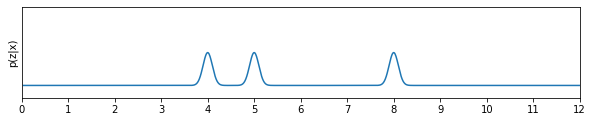

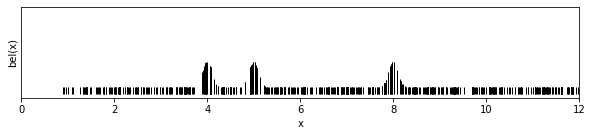

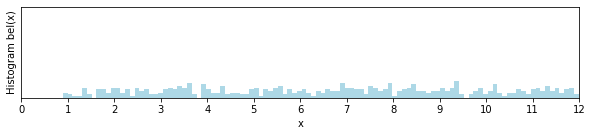

In [4]:
# Measurement model if door is seen
def p_z_door(x):
    return 0.1 \
        + 0.1 * norm.pdf(x, loc= 4.0, scale=0.1) \
        + 0.1 * norm.pdf(x, loc= 5.0, scale=0.1) \
        + 0.1 * norm.pdf(x, loc= 8.0, scale=0.1)

# Measurement model if door is not seen
def p_z_nothing(x):
    return 0.3 \
        - 0.05 * norm.pdf(x, loc= 4.0, scale=0.1) \
        - 0.05 * norm.pdf(x, loc= 5.0, scale=0.1) \
        - 0.05 * norm.pdf(x, loc= 8.0, scale=0.1)

def importance_factorization(position, particles, importance):
    if 3.7 < position < 4.3 or 4.7 < position < 5.3 or 7.7 < position < 8.3:
        p_z = p_z_door
    else:
        p_z = p_z_nothing
 
    # Set importance factor
    importance = list(map(p_z, particles))
    sum_importance = sum(importance)
    importance = [i / sum_importance for i in importance]
    
    particle_filter.plot_p(p_z)
    return particles, importance

particles, importance = importance_factorization(position, particles, importance)
particle_filter.plot_particles(particles, importance)

Das erste Diagramm zeigt die Wahrscheinlichkeitsdichteverteilung für das Zutreffen der Messung $z$ unter der Voraussetzung, dass der Zustand $x$ vorliegt.
Das zweite Diagramm zeigt die angenommene Wahrscheinlichkeit der Partikel, dass der Zustand $x$ wahr ist.
Das letzte Diagramm zeigt die Häufigkeit der Partikel. Da im Bereich der höheren Wahrscheinlichkeit eine bessere Auflösung des Zustandes sinnvoll ist, werden im nächten Schritt die Partikel neu verteilt.

#### Resampling

Nachdem jedem Partikel ein Gewicht (Importance Factor) zugewiesen wurde, wird nun die Verteilung der Partikel auf Basis dieser Gewichte angepasst. Dabei werden weniger wahrscheinliche Partikel weggelassen und dafür wahrscheinlichere Partikel vervielfältigt, sodass die Gesamtzahl der Partikel gleich bleibt.

Es gibt verschiedene Resampling-Algorithmen. Der hier vorgestellte ist das Low-Variance-Resampling. Bei diesem Algorithmus ist die Wahrscheinlichkeit des Resampling eines Zustandes proportional zu seinem Gewicht (d.h. zur geschätzten Wahrscheinlichkeit der Richtigkeit dieses Zustandes).

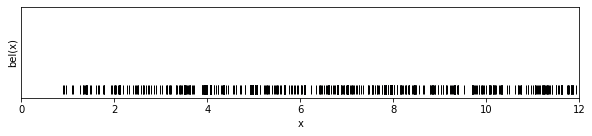

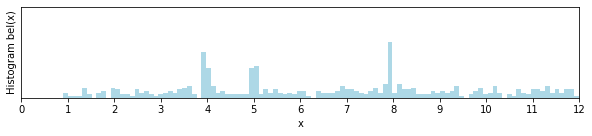

In [5]:
def resample_low_variance(particles, importance):
    length = len(particles)
    resampled_particles = []
    resampled_importance = []
    r = random.random() / float(length)
    c = importance[0]
    i = 0
    for m in range(length):
        U = r + ((float)(m) / (float)(length))
        while U > c:
            i += 1
            c += importance[i]
        resampled_particles.append(particles[i])
        resampled_importance.append(1.0 / length)
    return resampled_particles, resampled_importance

particles, importance = resample_low_variance(particles, importance)
particle_filter.plot_particles(particles, importance)

Alle Schritte in Kombination ergeben den Schleifeninhalt Partikel-Filter-Algorithmus für einen Zeitschritt $t$:

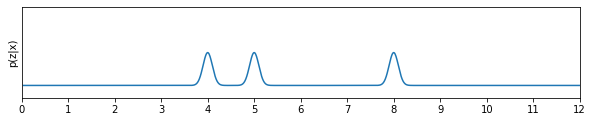

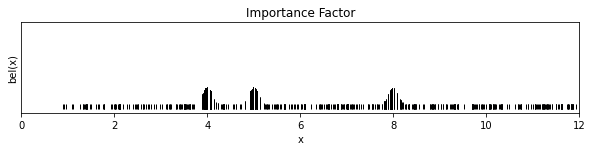

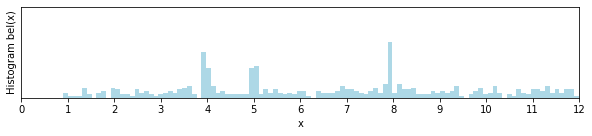

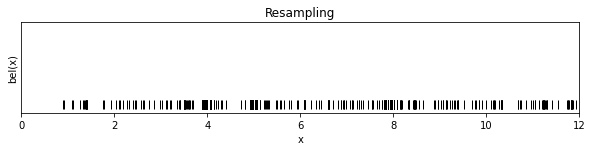

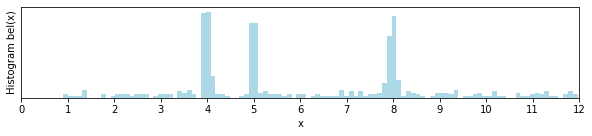

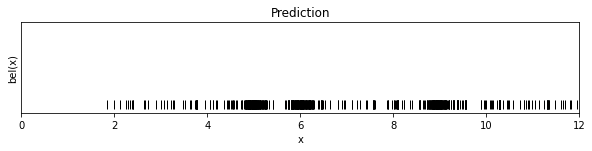

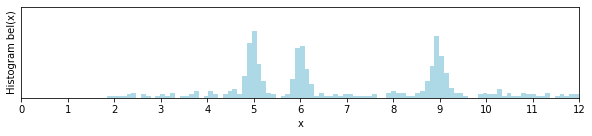

In [6]:
# Main loop of particle filter
particles, importance = importance_factorization(position, particles, importance)
particle_filter.plot_particles(particles, importance, "Importance Factor")
particles, importance = resample_low_variance(particles, importance)
particle_filter.plot_particles(particles, importance, "Resampling")
position, particles = predict(position, particles, 1.0)
particle_filter.plot_particles(particles, importance, "Prediction")

#### Fazit
In unserem Beispiel wurde mit dem Partikelfilter die Wahrscheinlichkeit für den Zustand "Objekt befindet sich auf Position $x = 6$" aufgrund der Beobachtungen als am größten eingeschätzt.
Je mehr Beobachtungen gemacht werden, desto öfter können die oben vorgestellten Schritte wiederholt werden und desto besser kann der wahre Zustand geschätzt werden.

# Bewegungsmodell

![Schematische Darstellung des angenommenen Bewegungsmodells](images/odometry_model.png)

### Darstellung im Zustandsraum

Der im Praktikum untersuchte Zustand ist nicht wie im Beispiel oben im 1D-Raum, sondern im 2D-Raum. Der Zustand des Roboters hat jeweils eine Position in den zwei Raumrichtungen, sowie eine Ausrichtung. Der Zustand bestitzt also drei Einträge. Für das Bewegungsmodell wird die Bewegung in eine Rotation $\delta_{rot1}$, eine Translation $\delta_{trans}$ und eine weitere Rotation $\delta_{rot2}$ aufgeteilt. Im nächsten Bild sind die Übergänge von zwei der drei Statusvariablen im Zustandsraum dargestellt.

* Prädiktionsschritt:
    Die Einträge des aktuell angenommenen Statuses (blau) werden mittels der Zustandsübergangsgleichung (schwarze Pfeile) in den nächsten Zustand überführt. Zusätzlich wird ein Rauschen hinzugefügt (gestrichelte Pfeile). Daraus ergibt sich der nächste Zustand im Zustandsraum (grün).

* Innovationsschritt: Zur Überprüfung der Voraussage wird eine Messung durchgeführt (rotes Kreuz). Die Voraussagen in der Nähe der Messung sind wahrscheinlicher und werden daher stärker gewichtet. Die Voraussagen, die weiter von der Messung entfernt sind, werden weniger stark gewichtet.

![Funktionsweise eines Partikelfilters](images/partikel_filter_uebersicht.png)

(Quelle: Vorlesungsfolie Automotive Vision, VL 05-Tracking, S.54, Jahr: 2019, KIT)

In [7]:
import random
import math
import numpy as np
from b2_slam import odometry as odom

# Initialization of variables
odom_pose = odom.Pose(0.0, 0.0, 0.0)
odom_particles = [odom.Pose(random.gauss(0.0, 0.02), random.gauss(0.0, 0.02), 
                            random.gauss(0.0, 0.001)) for i in range(100)]

Das im Versuch verwendete Bewegungsmodell basiert auf den Odometrie-Daten, d.h. den Radbewegungen. Diese Daten, bzw. Messungen, sind mit Unsicherheiten überlagert.

Das unten stehende Bild ist die Darstellung des Zustandsraumes in 2D (d.h. Raumrichtung 1 und 2). Die dritte Dimension (Ausrichtung des Roboters) wird durch die Richtung der Pfeile symbolisiert.

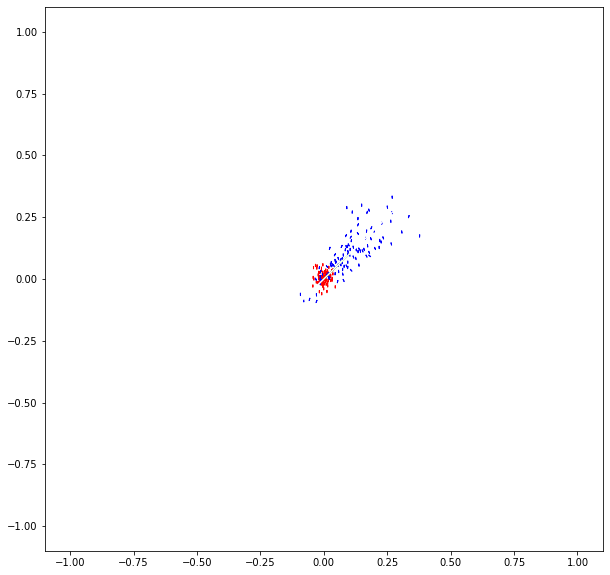

In [8]:
alpha_1a = 0.005  # changes in rotation causes uncertainty in rotation
alpha_1b = 0.01  # changes in rotation causes uncertainty in rotation
alpha_2 = 10.0  # changes in translation causes uncertainty in rotation
alpha_3 = 5.0  # changes in translation causes uncertainty in translation
alpha_4 = 0.0015  # changes in rotation causes uncertainty in translation
beta_rot_1 = 0.015  # uncertainty in rotation and translation
beta_rot_2 = 0.015  # uncertainty in translation
beta_trans = 0.015  # uncertainty in rotation

def sample_odometry_model(u_t, x_t_minus_1, delta_t):
    """
    sample_motion_model_odometry -> [Thrun06] page 136 table 5.6
    """
    atan2 = math.atan2(u_t[1].y - u_t[0].y, u_t[1].x - u_t[0].x)
    delta_rot_1 = atan2 - u_t[0].theta
    delta_trans = odom.pose_distance(u_t[1], u_t[0])
    delta_rot_2 = u_t[1].theta - u_t[0].theta - delta_rot_1

    # do not sample motion when standing
    if math.fabs(delta_trans) < 0.01 \
            and math.fabs(u_t[0].theta - u_t[1].theta) < 0.000001:
        return x_t_minus_1

    delta_rot_1_sample = delta_rot_1 - np.random.normal(
        scale=alpha_1a * pow(delta_rot_1, 2) + alpha_2 * pow(delta_trans, 2)
              + beta_rot_1)
    delta_trans_sample = delta_trans - np.random.normal(
        scale=alpha_3 * pow(delta_trans, 2) + alpha_4 * pow(delta_rot_1, 2)
              + alpha_4 * pow(delta_rot_2, 2) + beta_trans)
    delta_rot_2_sample = delta_rot_2 - np.random.normal(
        scale=alpha_1b * pow(delta_rot_2, 2) + alpha_2 * pow(delta_trans, 2)
              + beta_rot_2)

    x_t = odom.Pose(
        x_t_minus_1.x + delta_trans_sample * math.cos(x_t_minus_1.theta
            + delta_rot_1_sample),
        x_t_minus_1.y + delta_trans_sample * math.sin(x_t_minus_1.theta
            + delta_rot_1_sample),
        x_t_minus_1.theta + delta_rot_1_sample + delta_rot_2_sample)
    return x_t

next_pose = odom.Pose(odom_pose.x + 0.1, odom_pose.y + 0.1, odom_pose.theta)
u = (odom_pose, next_pose)
next_particles = []
for p in odom_particles:
    next_particles.append(sample_odometry_model(u, p, 1.0))
odom.plot_odom(odom_pose, odom_particles, 'r', next_pose, next_particles, 'b')
odom_pose = next_pose
odom_particles = next_particles


Im Versuch soll statt einem auf Odometriedaten basierenden Bewegungsmodells eines implementiert werden, dass nur die Schematische Zeichung oben zu Grunde legt und die tatsächliche Bewegungsrichtung und -weite nur durch Unsicherheit versucht abzubilden.

# Messmodell

Als Sensor dient hier ein 360° Scan eines einzeiligen Lidars. Dieser Scan $z_t$ besteht aus vielen einzelnen Messungen $z^k_t$ mit $0 \le k \le K-1$. Für jede dieser Messungen wird das folgende Sensormodell angenommen. Es beschreibt die Wahrscheinlichkeit der Entfernungsmessung gegeben einer Karte und einer Pose in der Karte (Zustand), die sich aus vier Teilaspekten zusammensetzt:

### Ähnlichkeit mit der Karte

Die Wahrscheinlichkeit $p_{\text{hit}}\left(z^k_t \middle| x_t, m \right)$ gibt an wie gut die Messung $z^k_t$ der Karte $m$ entspricht. 

In [9]:
import math
from b2_slam import sensors

sensors.sigma_hit = 0.05

def p_hit(dist_z_star_z, dist_x_t_z):
    if dist_x_t_z >= sensors.z_max:
        return 0.0
    else:
        # standard normal distribution
        return math.exp(-math.pow(dist_z_star_z / sensors.sigma_hit, 2) / 2.0) \
                / (math.sqrt(2.0 * math.pi))

### Unerwartetes Objekt

Der Term $p_{\text{short}}\left(z^k_t \middle| x_t, m \right)$ beschreibt die Wahrscheinlichkeit, dass ein Objekt gemessen wurde, dass (noch) nicht in der Karte verzeichnet ist oder erst aufgetaucht ist wie z.B. ein Mensch, der zwischen Roboter und Hindernis hindurchläuft.


In [10]:
sensors.lambda_short = 0.01

def p_short(dist_z_star_z, dist_x_t_z):
    if dist_x_t_z >= dist_z_star_z:
        return 0.0
    else:
        l = sensors.lambda_short
        return l * math.exp(-l * dist_x_t_z) / (1.0 - math.exp(-l * dist_x_t_z))

### Kein Objekt erfasst

Die Wahrscheinlichkeit, dass der Sensor kein Objekt im Messbereich erfasst hat und stattdessen den maximalen Distanzwert geliefert hat, wird mit $p_{\text{max}}\left(z^k_t \middle| x_t, m \right)$ angegeben.


In [11]:
sensors.z_max = 5.0

def p_max(dist_x_t_z):
    if dist_x_t_z >= sensors.z_max:
        return 1.0
    else:
        return 0.0

### Unerwartetes Messergebnis

Die Wahrscheinlichkeit $p_{\text{rand}}\left(z^k_t \middle| x_t, m \right)$ beschreibt, ob der Messwert unbrauchbar ist und sich nicht aus der direkten Umgebung ergibt z.B. durch Interferenzen mit einem anderen Sensor.


In [12]:
def p_rand(dist_x_t_z):
    if dist_x_t_z >= sensors.z_max:
        return 0.0
    else:
        return 1.0 / sensors.z_max

### Komplettes Messmodell

Da die einzelnen Wahrscheinlichkeiten abhängig vom verwendeten Sensor und der Umgebung sind, werden sie unterschiedlich gewichtet:

$$
p\left(z^k_t \middle| x_t, m \right) = w_{\text{hit}} \cdot p_{\text{hit}}\left(z^k_t \middle| x_t, m \right) 
                                     + w_{\text{short}} \cdot p_{\text{short}}\left(z^k_t \middle| x_t, m \right) 
                                     + w_{\text{max}} \cdot p_{\text{max}}\left(z^k_t \middle| x_t, m \right) 
                                     + w_{\text{rand}} \cdot p_{\text{rand}}\left(z^k_t \middle| x_t, m \right)
$$
$$
\ \text{mit}\ w_{\text{hit}} + w_{\text{short}} + w_{\text{max}} + w_{\text{rand}} = 1
$$

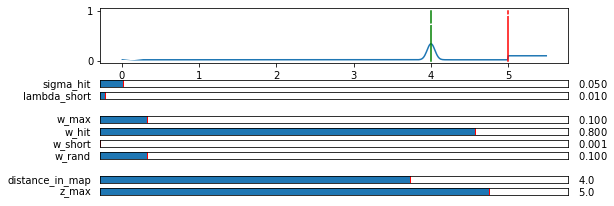

In [13]:
# sum of w_i has to be 1.0
sensors.w_max, sensors.w_hit, sensors.w_rand, sensors.w_short = 0.1, 0.8, 0.1, 0.0
sensors.distance_in_map = 4.0

def p_all(dist):
    p = sensors.w_max * p_max(dist) + sensors.w_rand * p_rand(dist)
    if sensors.distance_in_map is not None:
        difference = math.fabs(sensors.distance_in_map - dist)
        p += sensors.w_hit * p_hit(difference, dist) \
             + sensors.w_short * p_short(difference, dist)
    return p

sensors.plot_perception(p_all)

Die Wahrscheinlichkeit $p\left(z^k_t \middle| x_t, m \right)$ ist die Wahrscheinlichkeit einer Entfernungsmessung. Bei einem 360° Lidar fallen viele solcher Messungen an, die zu einer gesamten Wahrscheinlichkeit $p\left(z_t \middle| x_t, m \right)$ kombiniert werden müssen:

$$p\left(z_t \middle| x_t, m \right) = \prod_{k=0}^{K-1}p\left(z^k_t \middle| x_t, m \right) $$

# Lokalisierung

Als Lokalisierung wird die Aufgabe an einen Roboter bezeichnet, die eigene Position anhand von Messungen zu schätzen.
Wichtig ist, dass die Umgebung oder Karte schon im vorraus bekannt ist und der Roboter sich lediglich in dieser "lokalisieren" muss.
Dazu wird die Roboterposition als Zustand aufgefasst, womit die oben vorgestellten Filter verwendet werden können.
Etwa den Kalman-Filter oder den hier verwendeten Partikelfilter.
Mit dem Bewegungsmodell kann der geschätzte Zustand aktualisiert werden (Prädiktionsschritt) und mit dem Messmodell kann abgeschätzt werden welche Messungen zu welchen Zuständen passen (Filterschritt).

# Kartierung
War das Ziel der Lokalisierung die Schätzung der Position eines Roboters, ist die Kartierung im Gegensatz die Schätzung einer Karte bei bekannter Position des Roboters.
Eine besonders einfache Beschreibung der Karte erhält man mit den sogenannten Occupancy Grid Maps.

## Occupancy Grid Maps

Eine Occupancy-Grid-Map unterteilt die Welt in ein Gitter und speichert für jede Zelle die Wahrscheinlichkeit mit der diese frei (passierbar) oder verdeckt (Hindernis im Weg) ist.
(Quelle: Vorlesungsfolie Automotive Vision, VL 06-SLAM, S.42, Jahr: 2019, KIT)

<img src="images/occupancy_grid_bearbeitet.png" alt="Drawing" style="width: 350px;"/>

Für den Versuch B2 genügt eine vereinfachte Darstellung mit Einträgen für
- Belegt: Schwarz
- Frei: Weiß
- Unbekannt: Graustufen

Jedesmal wenn eine neue Messung gemacht wurde kann die Grid Map aktualisiert werden.
Der Algorithmus erhält dazu die neue Messung $z_t$ und die Schätzung der Roboterposition $x_t$.
Für einen einfachen Entfernungsmesser sind Messungen die Koordinaten bei dennen ein Hindernis detektiert wurde.

Als ersten Schritt im Algorithmus wird das Sichtfeld einer Messung berechnet.
Für eine Occupancy Grid Map sind dies alle Zellen die zwischen Roboter und einer Messung liegen.
Diese Zellen werden dann einzeln mit ihrer Belgeungswahrscheinlihckeit aktualisiert, welche vom sogenannten Inversen Sensor Modell berechnet wird.
In der Praxis ist es einfach mit dem Logarithmus der Wahrscheinlichkeiten $l$ zu rechnen als direkt mit den Wahrscheinlichkeiten $p$.

## Inverses Sensor Modell

Die Aufgabe des Inversen Sensor Modells ist es, abhängig von der Messung $z_t$, für jede Zelle $m_i$ im Sichtfeld die Log-Wahrscheinlichkeit $l$ für ein Hinderniss zu liefern.
Dabei werden der Abstand zwischen Roboter und Messung, die maximale Sensorreichweite und die Größe der Hindernisse berücksichtigt.
Wichtige Regeln dabei sind:

- Liegt die Zelle sehr nahe an einer Messung wird sie als besetzt behandelt $l_\text{occ}$
- Liegt die Zelle zwischen Roboter und Messung zählt sie als frei $l_\text{free}$
- Andere Fälle werden mit der *a priori* Log-Wahrscheinlichkeit $l_0$ bewertet

Die Log-Wahrscheinlichkeiten der einzelnen Fälle werden im Vorraus festgelegt.

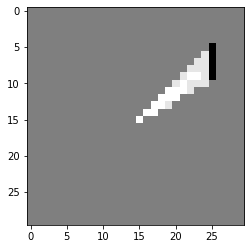

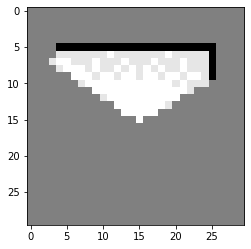

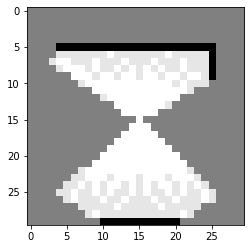

In [14]:
import math
import numpy as np
import sys
sys.path.append('lecture_modules/')
from b2_slam import grid_map


d_max = 15.0
l_occ, l_free, l_0 = 1.0, 0.1, 0.5
object_thickness = 0.04


def inverse_sensor_model(m_i, x_t, z_t):
    """
    inverse_range_sensor_model -> [Thrun06] page 288 table 9.2
    """
    d_obs = grid_map.map_distance(x_t, z_t)
    d_cell = grid_map.map_distance(x_t, m_i)
    if d_cell >= d_max:  # width of sensor beam not considered
        return l_0
    elif d_obs < d_max and math.fabs(d_cell - d_obs) < object_thickness / 2.0:
        return l_occ
    elif d_cell < d_obs:
        return l_free
    else:
        return l_0

    
def update_occupancy_grid(z_t, x_t):
    """
    occupancy_grid_mapping -> [Thrun06] page 286 table 9.1
    """
    perceptual_field = grid_map.get_perceptual_field(z_t, x_t)
    for cell in perceptual_field:
        grid_map.grid_map[cell] += inverse_sensor_model(cell, x_t, z_t) - l_0


grid_map.grid_map = np.full((30, 30), l_0)
robot_position = (15, 15)

for x in range(5):
    update_occupancy_grid((x + 5, 25), robot_position)
grid_map.plot_grid_map(robot_position, update_occupancy_grid)

for y in range(25):
    update_occupancy_grid((5, y), robot_position)
grid_map.plot_grid_map(robot_position, update_occupancy_grid)

for y in range(30):
    update_occupancy_grid((29, y), robot_position)
grid_map.plot_grid_map(robot_position, update_occupancy_grid)

## Grid-based FastSLAM

Einer der ersten und bekanntesten SLAM Algorithmen ist der EKF-SLAM, hierbei werden die Landmarken (in diesem Fall die Occupancy-Grid-Map) in den zu bestimmenden EKF Zustand mit aufgenommen. Die Komplexität der Berechnung steigt jedoch immens mit der Anzahl der Landmarken. Da in modernen Robotern immer größere und detaillierte Karten verwendet werden, stößt diese Art von Algorithmen schnell an ihre Grenzen. FastSLAM entkoppelt deshalb die Karte und deren Update von dem Zustand des Roboters.

Das im Praktikum verwendete FastSLAM ist eine Kombination der oben genannten Verfahren. Der Algorithmus ist für Distanzssensoren ohne eindeutige Marker ausgelegt. D.h. die erkannten Hindernisse sind dem Algorithmus bei Beginn der Aufzeichnung 
unbekannt und es gibt keine Karte, mit der die erkannten Strukturen der Hindernisse abgeglichen werden. Ein Partikelfilter dient zur Selbstlokalisierung, die Occupancy-Grid-Map wird basierend auf dem wahrscheinlichsten Partikel aktualisiert.
Der Pseudocode für eine Implementierung von FastSLAM für Occupancy-Grid-Maps ist im Folgenden dargestellt (aus *Probabilistic Robotics (Thrun, 2005)*):

$$
\begin{aligned}
\textbf{Algorithm } & \textbf{FastSLAM\_occupancy\_grids} \left(\mathcal{X}_{t-1}, u_t, z_t\right): \\
&\overline{\mathcal{X}}_t=\mathcal{X}_t=\emptyset \\
&\text{for } k=1 \text{ to } M \text{ do} \\
&\quad x_t^{[k]}=\text{sample\_motion\_model}\left(u_t, x_{t-1}^{[k]}\right) \\
&\quad w_t^{[k]}=\text{measurement\_model\_map}\left(z_t, x_t^{[k]}, m_{t-1}^{[k]}\right) \\
&\quad m_t^{[k]}=\text{updated\_occupancy\_grid}\left(z_t, x_t^{[k]}, m_{t-1}^{[k]}\right) \\
&\quad \overline{\mathcal{X}}_t=\overline{\mathcal{X}}_t+\left\langle x_t^{[k]}, m_t^{[k]}, w_t^{[k]}\right\rangle \\
&\text{ endfor } \\
&\text{ for } k=1 \text{ to } M \text { do } \\
&\quad \text { draw } i \text{ with probability } \propto w_t^{[i]} \\
&\quad \text{add}\left\langle x_t^{[i]}, m_t^{[i]}\right\rangle \text{to } \mathcal{X}_t \\
&\text{endfor} \\
&\text{return } \mathcal{X}_t
\end{aligned}
$$

Als Eingabe benötigt der Algorithmus die Zustände der Partikel zum Zeitpunkt t-1 $\mathcal{X}_{t-1}$, die Eingangsgrößen zum Zeitpunkt t $u_t$ und die Messungen zum Zeitpunkt t $z_t$. Für jeden Partikel wird zunächst der neue Zustand $x_t^{[k]}$ berechnet. Basierend auf diesem wird einem Partikel ein Gewicht $w_t^{[k]}$ zugeordnet, welches sich aus der Wahrscheinlichkeit der Messung $z_t$ unter der Bedingung des jeweiligen Partikelzustandes und der alten Karte $m_{t-1}^{[k]}$. Eine Karte wird für jeden Partikel separat gespeichert und auch separat mithilfe seines Zustandes und den Messungen aktualisiert. Wie bei dem regulären Partikelfilter wird schließlich ein Resampling der Partikel vorgenommen, mit dem Gewicht $w_t^{[k]}$ als Auswahlwahrscheinlichkeit. Die beste Karte für den Zeitpunkt t kann beispielsweise dem wahrscheinlichsten Partikel entnommen werden. 

# ROS
Die Abkürzung ROS steht für "Robot Operating System". Es handelt sich dabei nicht im eigentlichen Sinne um ein Betriebssystem, sondern viel mehr um ein Computerprogramm auf einem Linux-Betriebssystem mit dessen Hilfe sich die Kommunikation zwischen den einzelnen Komponenten (z.B. dem Roboter, einem externen Aktor, einem Algorithmus auf einem externem Computer) über einfache, standardisierte Verfahren realisieren lässt. ROS bildet ein Netztwerk über das die unterschiedlichen Teilnehmer kommunizieren können.
ROS löst also kein nicht anders lösbares Problem sondern erleichtert die Bedienbarkeit und schafft Übersichtlichkeit bei der Realisierung einer komplexen Kommunikation. Die in ROS verwendeten Sprachen sind Python und C++.

Die wesentlichen Elemente und Prinzipien von ROS sollen im Folgenden umrissen werden, um ein grundlegendes Verständnis zu schaffen. Für ein tieferes Verständnis sei auf http://wiki.ros.org/ROS/Tutorials verwiesen.

ROS setzt sich aus den folgenden Grundbausteinen zusammen

- Node: ROS-Begriff für ein Executable, das mit dem ROS-Netzwerk verbunden ist. Ein Node führt die Rechenarbeit eines Prozesses aus, um z.B. einen Aktor/Sensor anzusteuern, einen Weg zu planen oder eine graphische Darstellung zur Verfügung zu stellen. Ein Node wird in der ROS-client library geschrieben. Um den Node in Python zu schreiben verwendet man also `rospy`, für  C++ `roscpp`.
- Message: Eine Message ist eine Möglichkeit für Knoten untereinander zu kommunizieren. Z.B. möchte der Anzeige-Knoten Informationen über die Punkte, die er anzeigen soll. Dazu findet ein Informationsfluss zwischen Mess-Knoten und Anzeige-Knoten statt.
- Topics: Eine andere Art zwischen Knoten zu kommunizieren sind Topics. Ein Knoten der Informationen für viele andere Knoten veröffentlichen möchte muss auf diese Art nicht Messages an jeden einzelnen dieser Knoten schicken, sondern veröffentlicht ("publish") die Informationen auf einem Topic. Alle Knoten, die diese Informationen benötigen abonnieren das Topic ("subscribe").
- Service: Ein Service erlaubt die Freigabe eine Information von einem Knoten zum anderen. Dazu wird vom einen Knoten eine Anfrage ("request") geschickt, die vom anderen Knoten beantwortet wird ("response").
- Rosbag: Ein Format, um ROS-Message-Daten zu speichern und abzuspielen
- Package: Enthält Sammlung an anwendungsspezifischen Dateien (Nodes, libraries, configuration files, Datensätze etc.), die in unterschiedlichen Projekten gebraucht werden und vom Programmierer bei Bedarf eingebunden werden können.
- Meta-Package: Sammlung von Packages
- Konsolenbefehle: Die Kommunikation zwischen Anwender und ROS findet überwiegend in der Konsole statt. Einige wichtige Befehle sind
     - roscore: Startet ein ROS-Framework
     - rosrun: Führt ein ROS-Framework aus
     - rostopic: Gibt Informationen über die Topics zurück
     - rosmsg: Gibt Informationen über die Messages zurück
     - rossrv: Gibt Informationen über die Services zurück

Das folgende Bild zeigt einen ROS-Graphen für den im Praktikum behandelten Versuch. Darin sind die miteinander kommunizierenden Knoten dargestellt. Je nach Anwendung variiert der Graph stark.
Im diesem Beispiel erhält der Knoten "/rvmrt_slam" (rot), in dem der SLAM implementiert ist, Odometriedaten und Daten des Basescan von den Knoten "/odom" und "/base_scan" (blau), verarbeitet die Daten und gibt die verarbeiteten Daten an andere Knoten (grün) weiter.

<img src="images/rqt_graph.png" alt="Drawing" style="width: 600px;"/>

Der Knoten "/teleop_twist_keyboard" gibt Daten der Tastatur zum Knoten "/cmd_vel" weiter, der mit der seriellen Schnittstelle zwischen Computer und Roboter verknüpft ist. Mittels dieser Knoten wird der Roboter angesteuert. Sie sind unabhängig vom SLAM-Algorithmus.


## Kommunikation Computer-Roboter über serielle Schnittstelle

Der Roboter ist über eine serielle Schnittstelle mit dem Computer verbunden. Diese kann über das Terminal direkt über Befehle angesteuert werden. Dabei ist pro Befehl eine Zeile Code nötig. ROS vereinfacht diese Kommunikation, indem es die Codezeilen mittels eines Knoten direkt an die Schnittstelle überträgt. So kann der Roboter über Tastenbefehle gesteuert werden.

# Vorbereitung auf Versuch

1) Ein Roboter erkennt folgende Hindernisse in seinem 5 x 5 Sichtfeld:

   ![My Image alt text](images/Gitter.png)
  
   Der Roboter befindet sich im Feld (3|1) und hat einen Rundumblick in alle Richtungen. Erstellen Sie manuell ein Occupancy-Grid.
   * Kennzeichnen Sie die Felder jeweils mit: "X" = Belegt, "0" = Frei, "?" = Unsicher und "-" = Keine Beobachtung
   * Begründen Sie, weshalb unterschiedliche Lösungen möglich sind.

1) Schreiben Sie in Pseudocode wie eine mögliche Funktion zur Erstellung eines Occupancy-Grids aussehen könnte. Die Funktion akzeptiert als Eingabeparameter die Ortskoordinaten der Hindernisse.

1) Betracheten Sie das Video "Bsp_video_SLAM.avi" aus den Vorbereitungsunterlagen. Im Video sind aus der Vogelperspektive die abgeschätzten Koordinaten der Hindernisse (im Sichtfeld rot, nicht mehr im Sichtfeld blau) und die geschätzte Trajektorie des Roboters (in schwarz) dargestellt.
    * Warum ändern sich die geschätzten Koordinaten der Hindernisse in Sekunde 26, obwohl sie nicht im Sichtfeld des Roboters sind?
    * Warum weist die Schätzung der Trajektorie des Roboters bei mehreren Fahrten im Kreis wiederholt Sprünge an ähnlichen Koordinaten auf?

1) Erstellen Sie einen möglichen ROS-Graphen eines ferngesteuerten Spielzeugautos. Denken Sie sich dazu passende ROS-Nodes und ROS-Topics aus.

<!-- Placeholder to prevent creating a code block when running the block above. -->